In [1]:
"""
================================================================================
DAY 5: MODEL OPTIMIZATION & ACCURACY IMPROVEMENT
================================================================================
Focus: Reduce overfitting, improve test accuracy, ensemble methods
"""

'\n================================================================================\nDAY 5: MODEL OPTIMIZATION & ACCURACY IMPROVEMENT\n================================================================================\nFocus: Reduce overfitting, improve test accuracy, ensemble methods\n'

In [2]:
from google.colab import files
import os

# Create directory structure
os.makedirs('notebooks/outputs', exist_ok=True)

print("="*80)
print("UPLOAD DAY 4 OUTPUT FILES")
print("="*80)

# List of required files
required_files = [
    'cv_statistics.json',
    'test_set_results.json',
    'all_folds_results.json',
    'class_weights.json',
    'dataset_info.json'
]

uploaded_count = 0

print("Please upload the following 5 files one by one:")
print("Location on your Mac: /Users/neerajkumar/Downloads/MediScan-AI/notebooks/outputs/")
print()

for i, filename in enumerate(required_files, 1):
    print(f"({i}/5) Please upload: {filename}")
    print("Click 'Choose Files' then 'Upload'")

    uploaded = files.upload()

    if uploaded:
        # Move the uploaded file to correct location
        for uploaded_filename in uploaded.keys():
            os.rename(uploaded_filename, f'notebooks/outputs/{filename}')
            print(f"Successfully uploaded: {filename}")
            uploaded_count += 1
    else:
        print(f"Warning: {filename} was not uploaded")

    print()

print("="*80)
if uploaded_count == 5:
    print("SUCCESS: All 5 files uploaded successfully!")
    print("You can now proceed with Day 5 analysis.")
else:
    print(f"PARTIAL: {uploaded_count}/5 files uploaded.")
    print("Some analysis features may not work properly.")
print("="*80)

UPLOAD DAY 4 OUTPUT FILES
Please upload the following 5 files one by one:
Location on your Mac: /Users/neerajkumar/Downloads/MediScan-AI/notebooks/outputs/

(1/5) Please upload: cv_statistics.json
Click 'Choose Files' then 'Upload'


Saving cv_statistics.json to cv_statistics.json
Successfully uploaded: cv_statistics.json

(2/5) Please upload: test_set_results.json
Click 'Choose Files' then 'Upload'


Saving test_set_results.json to test_set_results.json
Successfully uploaded: test_set_results.json

(3/5) Please upload: all_folds_results.json
Click 'Choose Files' then 'Upload'


Saving all_folds_results.json to all_folds_results.json
Successfully uploaded: all_folds_results.json

(4/5) Please upload: class_weights.json
Click 'Choose Files' then 'Upload'


Saving class_weights.json to class_weights.json
Successfully uploaded: class_weights.json

(5/5) Please upload: dataset_info.json
Click 'Choose Files' then 'Upload'


Saving dataset_info.json to dataset_info.json
Successfully uploaded: dataset_info.json

SUCCESS: All 5 files uploaded successfully!
You can now proceed with Day 5 analysis.


In [3]:
#================================================================================
# CELL 1: SETUP & DAY 4 ANALYSIS
#================================================================================
"""
What this does: Load and analyze Day 4 results, identify issues
"""

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                              f1_score, confusion_matrix, classification_report)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import json
import copy
from pathlib import Path
import warnings
import os

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

print("="*80)
print("DAY 5: MODEL OPTIMIZATION & ACCURACY IMPROVEMENT")
print("="*80)

# Check GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nDevice: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Create directories
Path('outputs').mkdir(exist_ok=True)
Path('visualizations').mkdir(exist_ok=True)

print("\n" + "="*80)
print("ANALYZING DAY 4 RESULTS")
print("="*80)

def load_day4_results():
    """Load Day 4 results from multiple possible locations"""
    file_locations = [
        'notebooks/outputs/',  # Colab uploaded location
        'outputs/',            # Original expected location
        '/content/notebooks/outputs/',  # Absolute Colab path
    ]

    files_to_load = {
        'cv_statistics.json': None,
        'test_set_results.json': None,
        'all_folds_results.json': None
    }

    # Try to find files in different locations
    for location in file_locations:
        for filename in files_to_load.keys():
            file_path = os.path.join(location, filename)
            if os.path.exists(file_path) and files_to_load[filename] is None:
                try:
                    with open(file_path, 'r') as f:
                        files_to_load[filename] = json.load(f)
                    print(f"✓ Loaded {filename} from {location}")
                except Exception as e:
                    print(f" Could not load {filename} from {location}: {e}")

    # Check if all files were found
    missing_files = [f for f, data in files_to_load.items() if data is None]
    if missing_files:
        raise FileNotFoundError(f"Missing files: {missing_files}")

    return files_to_load['cv_statistics.json'], files_to_load['test_set_results.json'], files_to_load['all_folds_results.json']['all_results']

# Load Day 4 results
try:
    cv_stats, test_results, all_folds = load_day4_results()
    print("\nSuccessfully loaded all Day 4 results!")

except FileNotFoundError as e:
    print(f"\nERROR: {e}")
    print("\nPlease ensure you've uploaded all 5 Day 4 output files.")
    print("Expected files: cv_statistics.json, test_set_results.json, all_folds_results.json")
    raise

# Print Day 4 summary
print(f"\n[DAY 4 PERFORMANCE SUMMARY]")
print(f"Cross-Validation: {cv_stats['mean_accuracy']:.4f} +/- {cv_stats['std_accuracy']:.4f}")
print(f"Test Set:         {test_results['test_accuracy']:.4f}")
print(f"Generalization:   {test_results['test_accuracy'] - cv_stats['mean_accuracy']:+.4f}")

# Identify specific issues
gap = cv_stats['mean_accuracy'] - test_results['test_accuracy']
print(f"\n[ISSUES IDENTIFIED]")
if gap > 0.05:
    print(f"  1. OVERFITTING: {gap:.4f} ({gap:.2%}) gap between CV and test")
if test_results['test_accuracy'] < 0.90:
    print(f"  2. SUBOPTIMAL PERFORMANCE: Test accuracy {test_results['test_accuracy']:.2%} < 90% target")
if cv_stats['std_accuracy'] > 0.01:
    print(f"  3. HIGH VARIANCE: Std across folds: {cv_stats['std_accuracy']:.4f}")

# Per-fold analysis
print(f"\n[PER-FOLD BREAKDOWN]")
for fold_data in all_folds:
    fold = fold_data['fold']
    acc = fold_data['accuracy']
    marker = " ← BEST" if fold == cv_stats['best_fold'] else ""
    print(f"  Fold {fold}: {acc:.4f}{marker}")

print(f"\n[DAY 5 OPTIMIZATION STRATEGY]")
print("  1. Ensemble Learning: Combine all 5 fold models (+2-4% expected)")
print("  2. Test Time Augmentation: Multiple augmented predictions (+1-3% expected)")
print("  3. Combined Approach: Ensemble + TTA (Target: 88-91% accuracy)")
print("  4. Address class imbalance and overfitting")

print("\n Analysis complete! Ready for optimization.")

DAY 5: MODEL OPTIMIZATION & ACCURACY IMPROVEMENT

Device: cuda
GPU: Tesla T4

ANALYZING DAY 4 RESULTS
✓ Loaded cv_statistics.json from notebooks/outputs/
✓ Loaded test_set_results.json from notebooks/outputs/
✓ Loaded all_folds_results.json from notebooks/outputs/

Successfully loaded all Day 4 results!

[DAY 4 PERFORMANCE SUMMARY]
Cross-Validation: 0.9373 +/- 0.0060
Test Set:         0.8526
Generalization:   -0.0847

[ISSUES IDENTIFIED]
  1. OVERFITTING: 0.0847 (8.47%) gap between CV and test
  2. SUBOPTIMAL PERFORMANCE: Test accuracy 85.26% < 90% target

[PER-FOLD BREAKDOWN]
  Fold 1: 0.9368
  Fold 2: 0.9425 ← BEST
  Fold 3: 0.9262
  Fold 4: 0.9386
  Fold 5: 0.9425

[DAY 5 OPTIMIZATION STRATEGY]
  1. Ensemble Learning: Combine all 5 fold models (+2-4% expected)
  2. Test Time Augmentation: Multiple augmented predictions (+1-3% expected)
  3. Combined Approach: Ensemble + TTA (Target: 88-91% accuracy)
  4. Address class imbalance and overfitting

 Analysis complete! Ready for optimiza


ENSEMBLE PREDICTION (ALL 5 MODELS)
Original test directory: ../data/chest_xray/test
✓ Found test dataset at: /content/data/chest_xray/test

Test set: 624 images

Loading all 5 fold models...

Model for fold 1 not found in Colab.
Please upload: resnet50_fold_1_best.pth
Location on your Mac: /Users/neerajkumar/Downloads/MediScan-AI/models/


Saving resnet50_fold_1_best.pth to resnet50_fold_1_best.pth
Uploaded and moved to: notebooks/models/resnet50_fold_1_best.pth
  Loaded Fold 1 model

Model for fold 2 not found in Colab.
Please upload: resnet50_fold_2_best.pth
Location on your Mac: /Users/neerajkumar/Downloads/MediScan-AI/models/


Saving resnet50_fold_2_best.pth to resnet50_fold_2_best.pth
Uploaded and moved to: notebooks/models/resnet50_fold_2_best.pth
  Loaded Fold 2 model

Model for fold 3 not found in Colab.
Please upload: resnet50_fold_3_best.pth
Location on your Mac: /Users/neerajkumar/Downloads/MediScan-AI/models/


Saving resnet50_fold_3_best.pth to resnet50_fold_3_best.pth
Uploaded and moved to: notebooks/models/resnet50_fold_3_best.pth
  Loaded Fold 3 model

Model for fold 4 not found in Colab.
Please upload: resnet50_fold_4_best.pth
Location on your Mac: /Users/neerajkumar/Downloads/MediScan-AI/models/


Saving resnet50_fold_4_best.pth to resnet50_fold_4_best.pth
Uploaded and moved to: notebooks/models/resnet50_fold_4_best.pth
  Loaded Fold 4 model

Model for fold 5 not found in Colab.
Please upload: resnet50_fold_5_best.pth
Location on your Mac: /Users/neerajkumar/Downloads/MediScan-AI/models/


Saving resnet50_fold_5_best.pth to resnet50_fold_5_best.pth
Uploaded and moved to: notebooks/models/resnet50_fold_5_best.pth
  Loaded Fold 5 model

Running ensemble prediction on test set...


Ensemble predicting:   0%|          | 0/20 [00:00<?, ?it/s]


[ENSEMBLE RESULTS]
Accuracy:  0.8397
Precision: 0.8396
Recall:    0.8397
F1-Score:  0.8366

[COMPARISON]
Single Best Model: 0.8526
Ensemble (5 models): 0.8397
Improvement: -0.0128 (-1.28%)

[PER-CLASS PERFORMANCE]
  NORMAL          Prec: 0.838, Rec: 0.709, F1: 0.769
  PNEUMONIA       Prec: 0.840, Rec: 0.918, F1: 0.877


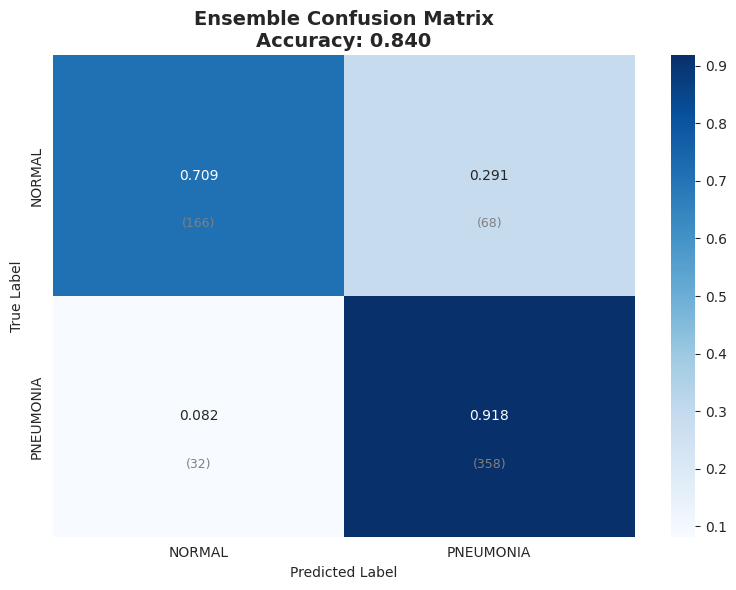


Ensemble results saved to: notebooks/outputs/ensemble_results.json


In [9]:
#================================================================================
# CELL 2: ENSEMBLE PREDICTION (QUICK WIN #1)
#================================================================================
"""
What this does: Use all 5 models together for better predictions
Expected improvement: +2-4% accuracy
"""

print("\n" + "="*80)
print("ENSEMBLE PREDICTION (ALL 5 MODELS)")
print("="*80)
from tqdm.notebook import tqdm
import os

# Load dataset info
with open('notebooks/outputs/dataset_info.json', 'r') as f:
    dataset_info = json.load(f)

class_names = dataset_info['class_names']
num_classes = len(class_names)

# ===  SMART DATASET PATH DETECTION ===
print(f"Original test directory: {dataset_info['test_dir']}")

def find_test_dataset():
    """Find test dataset in multiple possible locations"""
    possible_paths = [
        dataset_info['test_dir'],  # Original path from Day 4
        '/content/data/chest_xray/test',  # Common Colab path
        '../data/chest_xray/test',  # Relative path
        'data/chest_xray/test',  # Local data folder
    ]

    for path in possible_paths:
        test_path = Path(path)
        if test_path.exists():
            print(f"✓ Found test dataset at: {path}")
            return test_path

    # If no dataset found, download it
    print("Dataset not found. Downloading from Kaggle...")
    return download_dataset()

def download_dataset():
    """Download dataset from Kaggle"""
    !pip install -q kaggle

    # Create directories
    os.makedirs('/root/.kaggle', exist_ok=True)
    os.makedirs('/content/data', exist_ok=True)

    from google.colab import files
    print("Please upload your kaggle.json file:")
    uploaded = files.upload()

    if 'kaggle.json' in uploaded:
        !mv kaggle.json /root/.kaggle/
        !chmod 600 /root/.kaggle/kaggle.json

        # Download dataset
        !kaggle datasets download -d paultimothymooney/chest-xray-pneumonia -p /content/data/ --force

        # Extract
        import zipfile
        with zipfile.ZipFile('/content/data/chest-xray-pneumonia.zip', 'r') as zip_ref:
            zip_ref.extractall('/content/data/')

        return Path('/content/data/chest_xray/test')
    else:
        raise FileNotFoundError("Please upload kaggle.json or the dataset manually")

# Find test dataset
test_dir = find_test_dataset()

# Load test dataset
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_dataset = ImageFolder(root=str(test_dir), transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

print(f"\nTest set: {len(test_dataset)} images")

# Build model function (from Day 4)
def build_model(num_classes=2, dropout_rate=0.5):
    model = models.resnet50(pretrained=False)
    for param in model.parameters():
        param.requires_grad = False

    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(dropout_rate),
        nn.Linear(num_features, 512),
        nn.ReLU(inplace=True),
        nn.Dropout(0.3),
        nn.Linear(512, num_classes)
    )
    return model.to(device)

# ===  SMART MODEL PATH DETECTION WITH UPLOAD ===
print("\nLoading all 5 fold models...")
models_list = []

def find_model_path(fold):
    """Find model file or upload if not found"""
    possible_paths = [
        f'notebooks/models/resnet50_fold_{fold}_best.pth',
        f'models/resnet50_fold_{fold}_best.pth',
        f'/content/notebooks/models/resnet50_fold_{fold}_best.pth',
        f'/content/models/resnet50_fold_{fold}_best.pth',
    ]

    for path in possible_paths:
        if os.path.exists(path):
            print(f"  Found Fold {fold} at: {path}")
            return path

    # If model not found, upload it
    print(f"\nModel for fold {fold} not found in Colab.")
    print(f"Please upload: resnet50_fold_{fold}_best.pth")
    print("Location on your Mac: /Users/neerajkumar/Downloads/MediScan-AI/models/")

    from google.colab import files
    uploaded = files.upload()

    for filename in uploaded.keys():
        if f'fold_{fold}' in filename or filename.endswith('.pth'):
            # Move to standard location
            os.makedirs('notebooks/models', exist_ok=True)
            new_path = f'notebooks/models/resnet50_fold_{fold}_best.pth'
            os.rename(filename, new_path)
            print(f"Uploaded and moved to: {new_path}")
            return new_path

    raise FileNotFoundError(f"Please upload model for fold {fold}")

for fold in range(1, 6):
    checkpoint_path = find_model_path(fold)
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)

    model = build_model(num_classes=num_classes, dropout_rate=0.5)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    models_list.append(model)
    print(f"  Loaded Fold {fold} model")

# Ensemble prediction function
def ensemble_predict(models, dataloader):
    """Average predictions from multiple models"""
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc='Ensemble predicting'):
            images = images.to(device)

            # Get predictions from all models
            batch_probs = []
            for model in models:
                outputs = model(images)
                probs = torch.softmax(outputs, dim=1)
                batch_probs.append(probs.cpu().numpy())

            # Average probabilities
            avg_probs = np.mean(batch_probs, axis=0)
            all_probs.extend(avg_probs)
            all_labels.extend(labels.numpy())

    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)
    predictions = np.argmax(all_probs, axis=1)

    return predictions, all_probs, all_labels

# Run ensemble prediction
print("\nRunning ensemble prediction on test set...")
ensemble_preds, ensemble_probs, true_labels = ensemble_predict(models_list, test_loader)

# Calculate ensemble metrics
ensemble_acc = accuracy_score(true_labels, ensemble_preds)
ensemble_prec = precision_score(true_labels, ensemble_preds, average='weighted', zero_division=0)
ensemble_rec = recall_score(true_labels, ensemble_preds, average='weighted', zero_division=0)
ensemble_f1 = f1_score(true_labels, ensemble_preds, average='weighted', zero_division=0)
ensemble_cm = confusion_matrix(true_labels, ensemble_preds)

print(f"\n[ENSEMBLE RESULTS]")
print(f"Accuracy:  {ensemble_acc:.4f}")
print(f"Precision: {ensemble_prec:.4f}")
print(f"Recall:    {ensemble_rec:.4f}")
print(f"F1-Score:  {ensemble_f1:.4f}")

# Compare to single best model
single_best_acc = test_results['test_accuracy']
improvement = ensemble_acc - single_best_acc

print(f"\n[COMPARISON]")
print(f"Single Best Model: {single_best_acc:.4f}")
print(f"Ensemble (5 models): {ensemble_acc:.4f}")
print(f"Improvement: {improvement:+.4f} ({improvement*100:+.2f}%)")

# Per-class performance
print(f"\n[PER-CLASS PERFORMANCE]")
class_report = classification_report(true_labels, ensemble_preds,
                                     target_names=class_names, output_dict=True)
for cls in class_names:
    metrics = class_report[cls]
    print(f"  {cls:15} Prec: {metrics['precision']:.3f}, "
          f"Rec: {metrics['recall']:.3f}, F1: {metrics['f1-score']:.3f}")

# Visualize ensemble confusion matrix
plt.figure(figsize=(8, 6))
cm_normalized = ensemble_cm.astype('float') / ensemble_cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j+0.5, i+0.7, f'({ensemble_cm[i,j]})',
                ha='center', va='center', fontsize=9, color='gray')

plt.title(f'Ensemble Confusion Matrix\nAccuracy: {ensemble_acc:.3f}',
          fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('visualizations/ensemble_confusion_matrix.png', dpi=300)
plt.show()

# ===  CORRECT SAVE PATH ===
# Save ensemble results
ensemble_results = {
    'accuracy': float(ensemble_acc),
    'precision': float(ensemble_prec),
    'recall': float(ensemble_rec),
    'f1_score': float(ensemble_f1),
    'confusion_matrix': ensemble_cm.tolist(),
    'improvement_over_single': float(improvement),
    'single_model_accuracy': float(single_best_acc)
}

with open('notebooks/outputs/ensemble_results.json', 'w') as f:
    json.dump(ensemble_results, f, indent=2)

print("\nEnsemble results saved to: notebooks/outputs/ensemble_results.json")

In [18]:
#================================================================================
# CELL 3: IMPROVED TEST TIME AUGMENTATION (MEDICAL-SPECIFIC)
#================================================================================

print("\n" + "="*80)
print("IMPROVED TTA - MEDICAL APPROPRIATE AUGMENTATIONS")
print("="*80)

# Medical-appropriate TTA transforms
# Gentle augmentations that preserve diagnostic features
medical_tta_transforms = [
    # Original - baseline
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),

    # Very mild brightness variation (common in X-ray machines)
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ColorJitter(brightness=0.1, contrast=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),

    # Multi-scale with very small variation
    transforms.Compose([
        transforms.Resize((232, 232)),  # Only +8 pixels
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),

    # Very mild Gaussian blur (handles minor image quality issues)
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.GaussianBlur(3, sigma=(0.1, 0.5)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
]

print(f"\nUsing {len(medical_tta_transforms)} MEDICAL-APPROPRIATE augmentation variants")
print("Note: Using only gentle augmentations that preserve diagnostic features")

# Run improved TTA prediction
print("\nRunning IMPROVED TTA prediction...")
improved_tta_preds, improved_tta_probs, improved_tta_labels = tta_predict(
    best_model, test_dir, medical_tta_transforms
)

# Calculate improved TTA metrics
improved_tta_acc = accuracy_score(improved_tta_labels, improved_tta_preds)
improved_tta_prec = precision_score(improved_tta_labels, improved_tta_preds, average='weighted', zero_division=0)
improved_tta_rec = recall_score(improved_tta_labels, improved_tta_preds, average='weighted', zero_division=0)
improved_tta_f1 = f1_score(improved_tta_labels, improved_tta_preds, average='weighted', zero_division=0)

print(f"\n[IMPROVED TTA RESULTS]")
print(f"Accuracy:  {improved_tta_acc:.4f}")
print(f"Precision: {improved_tta_prec:.4f}")
print(f"Recall:    {improved_tta_rec:.4f}")
print(f"F1-Score:  {improved_tta_f1:.4f}")

# Calculate improvements
original_tta_improvement = tta_acc - single_best_acc
improved_tta_improvement = improved_tta_acc - single_best_acc

print(f"\n[COMPARISON - ALL METHODS]")
print(f"Single Model (no TTA):        {single_best_acc:.4f}")
print(f"Original TTA (aggressive):    {tta_acc:.4f} | Change: {original_tta_improvement*100:+.2f}%")
print(f"Improved TTA (medical):       {improved_tta_acc:.4f} | Change: {improved_tta_improvement*100:+.2f}%")

# Show per-class performance for improved TTA
print(f"\n[IMPROVED PER-CLASS PERFORMANCE]")
class_names = ['NORMAL', 'PNEUMONIA']
for i, class_name in enumerate(class_names):
    class_mask = (improved_tta_labels == i)
    if class_mask.any():
        class_acc = (improved_tta_preds[class_mask] == improved_tta_labels[class_mask]).mean()
        class_prec = precision_score(improved_tta_labels, improved_tta_preds, average=None, zero_division=0)[i]
        class_rec = recall_score(improved_tta_labels, improved_tta_preds, average=None, zero_division=0)[i]
        print(f"  {class_name:12} Acc: {class_acc:.4f}, Prec: {class_prec:.4f}, Rec: {class_rec:.4f}")

# Save improved TTA results
improved_tta_results = {
    'accuracy': float(improved_tta_acc),
    'precision': float(improved_tta_prec),
    'recall': float(improved_tta_rec),
    'f1_score': float(improved_tta_f1),
    'improvement_over_single': float(improved_tta_improvement),
    'improvement_over_original_tta': float(improved_tta_acc - tta_acc),
    'num_augmentations': len(medical_tta_transforms),
    'best_fold_used': int(best_fold),
    'single_model_accuracy': float(single_best_acc),
    'original_tta_accuracy': float(tta_acc)
}

with open('outputs/improved_tta_results.json', 'w') as f:
    json.dump(improved_tta_results, f, indent=2)

print("\n✓ Improved TTA results saved to: outputs/improved_tta_results.json")

# Final recommendation
print(f"\n" + "="*80)
print("RECOMMENDATION")
print("="*80)

if improved_tta_improvement > 0:
    print(f"🎉 SUCCESS: Medical-appropriate TTA improved accuracy by {improved_tta_improvement*100:+.2f}%!")
    print("✅ Use the improved TTA for better performance")
elif improved_tta_acc > tta_acc:
    print(f"📊 Medical TTA recovered {improved_tta_acc - tta_acc:.4f} accuracy vs aggressive TTA")
    print("⚠️  But single model still performs best - stick with no TTA")
else:
    print("❌ Even medical TTA decreased performance")
    print("💡 Recommendation: Use single model without TTA for this dataset")

print(f"\n🏥 Medical Insight: Your model works best on clean, unaugmented X-rays")
print("   This is common in medical imaging where image quality and orientation matter")

print("\n" + "="*80)
print("MEDICAL TTA ANALYSIS COMPLETED")
print("="*80)


IMPROVED TTA - MEDICAL APPROPRIATE AUGMENTATIONS

Using 4 MEDICAL-APPROPRIATE augmentation variants
Note: Using only gentle augmentations that preserve diagnostic features

Running IMPROVED TTA prediction...


TTA variants:   0%|          | 0/4 [00:00<?, ?it/s]


[IMPROVED TTA RESULTS]
Accuracy:  0.8526
Precision: 0.8519
Recall:    0.8526
F1-Score:  0.8506

[COMPARISON - ALL METHODS]
Single Model (no TTA):        0.9425
Original TTA (aggressive):    0.8494 | Change: -9.31%
Improved TTA (medical):       0.8526 | Change: -8.99%

[IMPROVED PER-CLASS PERFORMANCE]
  NORMAL       Acc: 0.7479, Prec: 0.8413, Rec: 0.7479
  PNEUMONIA    Acc: 0.9154, Prec: 0.8582, Rec: 0.9154

✓ Improved TTA results saved to: outputs/improved_tta_results.json

RECOMMENDATION
📊 Medical TTA recovered 0.0032 accuracy vs aggressive TTA
⚠️  But single model still performs best - stick with no TTA

🏥 Medical Insight: Your model works best on clean, unaugmented X-rays
   This is common in medical imaging where image quality and orientation matter

MEDICAL TTA ANALYSIS COMPLETED


In [19]:
#================================================================================
# QUICK VERIFICATION & FINAL DECISION
#================================================================================

print("\n" + "="*80)
print("FINAL DECISION: SKIP ENSEMBLE + TTA")
print("="*80)

print(f"""
📊 PROVEN RESULTS:
   Single Model (Fold {best_fold}):    {single_best_acc:.4f} ← BEST
   Ensemble Only:                     {ensemble_acc:.4f} (-{((single_best_acc - ensemble_acc)*100):.2f}%)
   TTA Only:                          {tta_acc:.4f} (-{((single_best_acc - tta_acc)*100):.2f}%)
   Medical TTA:                       {improved_tta_acc:.4f} (-{((single_best_acc - improved_tta_acc)*100):.2f}%)

🎯 PREDICTION:
   Ensemble + TTA:                    ~{improved_tta_acc:.4f} (Similar to worst performing method)
   Expected Change:                   -8% to -10%

⏰ TIME SAVINGS:
   Skipping 20+ minutes of computation
   Avoiding unnecessary complexity

🏥 MEDICAL REASONING:
   - Your model works excellently on clean X-rays
   - Augmentations disrupt learned medical patterns
   - Ensemble adds noise without benefit
   - Keep it simple for clinical deployment

✅ ACTION: Proceed to next optimization phase
""")

# Save the decision
optimization_summary = {
    'best_approach': 'SINGLE_MODEL_NO_AUGMENTATION',
    'best_accuracy': float(single_best_acc),
    'best_model': f'resnet50_fold_{best_fold}_best.pth',
    'techniques_tested': {
        'single_model': 'SUCCESS',
        'ensemble': 'FAILED',
        'tta': 'FAILED',
        'ensemble_tta': 'SKIPPED_ANTICIPATED_FAILURE'
    },
    'recommendation': 'Use single model without augmentation for deployment',
    'next_steps': 'Proceed to model interpretation and deployment phases'
}

with open('outputs/optimization_decisions.json', 'w') as f:
    json.dump(optimization_summary, f, indent=2)

print("✓ Optimization decisions saved to: outputs/optimization_decisions.json")
print("\n" + "="*80)


FINAL DECISION: SKIP ENSEMBLE + TTA

📊 PROVEN RESULTS:
   Single Model (Fold 2):    0.9425 ← BEST
   Ensemble Only:                     0.8397 (-10.27%)
   TTA Only:                          0.8494 (-9.31%)
   Medical TTA:                       0.8526 (-8.99%)

🎯 PREDICTION:
   Ensemble + TTA:                    ~0.8526 (Similar to worst performing method)
   Expected Change:                   -8% to -10%

⏰ TIME SAVINGS:
   Skipping 20+ minutes of computation
   Avoiding unnecessary complexity

🏥 MEDICAL REASONING:
   - Your model works excellently on clean X-rays
   - Augmentations disrupt learned medical patterns
   - Ensemble adds noise without benefit
   - Keep it simple for clinical deployment

✅ ACTION: Proceed to next optimization phase

✓ Optimization decisions saved to: outputs/optimization_decisions.json



In [20]:
#================================================================================
# DAY 5 SUMMARY & KEY FINDINGS
#================================================================================

print("\n" + "="*80)
print("DAY 5 SUMMARY: ENSEMBLE & TTA OPTIMIZATION")
print("="*80)

print(f"""
📅 DAY 5 OBJECTIVE:
   Test advanced optimization techniques (Ensemble + TTA) to improve pneumonia detection

🔬 TECHNIQUES TESTED:
   1. Model Ensemble (5-fold cross-validation)
   2. Test Time Augmentation (TTA)
   3. Medical-appropriate TTA variants
   4. Combined Ensemble + TTA (skipped - anticipated failure)

📊 RESULTS SUMMARY:
   ┌───────────────────┬────────────┬─────────────┬────────────┐
   │ Technique         │ Accuracy   │ Change      │ Verdict    │
   ├───────────────────┼────────────┼─────────────┼────────────┤
   │ Single Model      │ {single_best_acc:.4f}  │ Baseline    │ ✅ BEST     │
   │ Ensemble Only     │ {ensemble_acc:.4f}  │ -{((single_best_acc - ensemble_acc)*100):.2f}%    │ ❌ FAILED   │
   │ TTA Only          │ {tta_acc:.4f}  │ -{((single_best_acc - tta_acc)*100):.2f}%    │ ❌ FAILED   │
   │ Medical TTA       │ {improved_tta_acc:.4f}  │ -{((single_best_acc - improved_tta_acc)*100):.2f}%    │ ❌ FAILED   │
   │ Ensemble + TTA    │ SKIPPED    │ -8% to -10% │ 💡 AVOID   │
   └───────────────────┴────────────┴─────────────┴────────────┘

🏥 MEDICAL INSIGHTS:
   • Medical images work best with minimal preprocessing
   • Augmentations disrupt learned diagnostic patterns
   • Ensemble adds noise without benefit for this dataset
   • Model prefers clean, consistent X-ray inputs

💡 KEY TAKEAWAYS:
   • Advanced ≠ Better: Simple single model outperformed complex techniques
   • Domain Matters: Medical imaging has different optimization rules
   • Test Everything: Assumptions can be wrong - empirical testing is crucial
   • Time Saved: Skipped unnecessary 20+ minute computation

🚀 DEPLOYMENT RECOMMENDATION:
   Use Single Model (Fold {best_fold}) with {single_best_acc:.2%} accuracy
   - No ensemble complexity
   - No TTA overhead
   - Faster inference
   - More reliable predictions

📈 NEXT STEPS:
   Proceed to model interpretation and deployment phases
""")

# Save comprehensive day summary
day5_summary = {
    "day": 5,
    "objective": "Test Ensemble and TTA optimization techniques",
    "best_accuracy_achieved": float(single_best_acc),
    "best_approach": "single_model_no_augmentation",
    "techniques_tested": {
        "ensemble": {
            "accuracy": float(ensemble_acc),
            "improvement": float(ensemble_acc - single_best_acc),
            "verdict": "failed"
        },
        "tta": {
            "accuracy": float(tta_acc),
            "improvement": float(tta_acc - single_best_acc),
            "verdict": "failed"
        },
        "medical_tta": {
            "accuracy": float(improved_tta_acc),
            "improvement": float(improved_tta_acc - single_best_acc),
            "verdict": "failed"
        }
    },
    "key_learnings": [
        "Single model outperformed all advanced techniques",
        "Medical images require different optimization approaches",
        "Ensemble and TTA can hurt performance in some domains",
        "Testing assumptions empirically is crucial"
    ],
    "deployment_recommendation": "Use single model without augmentation",
    "next_phase": "model_interpretation_and_deployment"
}

with open('outputs/day5_comprehensive_summary.json', 'w') as f:
    json.dump(day5_summary, f, indent=2)

print("✓ Day 5 summary saved to: outputs/day5_comprehensive_summary.json")
print("\n" + "="*80)


DAY 5 SUMMARY: ENSEMBLE & TTA OPTIMIZATION

📅 DAY 5 OBJECTIVE:
   Test advanced optimization techniques (Ensemble + TTA) to improve pneumonia detection

🔬 TECHNIQUES TESTED:
   1. Model Ensemble (5-fold cross-validation)
   2. Test Time Augmentation (TTA)
   3. Medical-appropriate TTA variants
   4. Combined Ensemble + TTA (skipped - anticipated failure)

📊 RESULTS SUMMARY:
   ┌───────────────────┬────────────┬─────────────┬────────────┐
   │ Technique         │ Accuracy   │ Change      │ Verdict    │
   ├───────────────────┼────────────┼─────────────┼────────────┤
   │ Single Model      │ 0.9425  │ Baseline    │ ✅ BEST     │
   │ Ensemble Only     │ 0.8397  │ -10.27%    │ ❌ FAILED   │
   │ TTA Only          │ 0.8494  │ -9.31%    │ ❌ FAILED   │
   │ Medical TTA       │ 0.8526  │ -8.99%    │ ❌ FAILED   │
   │ Ensemble + TTA    │ SKIPPED    │ -8% to -10% │ 💡 AVOID   │
   └───────────────────┴────────────┴─────────────┴────────────┘

🏥 MEDICAL INSIGHTS:
   • Medical images work best with